In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
tqdm.pandas()

In [2]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from plotly.subplots import make_subplots
import joblib as jb
import pickle as pk
import sys
import gc

In [3]:
os.chdir("D:/LargeDatasets/MicrosoftMalware/")


## Final DataSet Preparation

In [4]:
final_files = os.listdir("./final_features/")

In [5]:
df=pd.read_csv("./final_features/"+final_files[0])
print(final_files[0]+" merged")
for i in range(1,len(final_files)):
    df = pd.merge(df, pd.read_csv("./final_features/"+final_files[i]),on=['ID','Class'], how='left')
    print(final_files[i]+" merged")
df.shape

asm_file_count_features.csv merged
asm_img_features.csv merged
byte_four_gram_hash_encoded_features.csv merged
byte_img_features.csv merged
byte_two_gram_features.csv merged
one_gram_byte.csv merged


(10868, 9560)

In [6]:
df.head()

ID  HEADER:  .text:  .Pav:  .idata:   .data:  .bss:  \
0  01azqd4InC7m9JpocGv5       18   22430      0     1158  1366754      0   
1  01IsoiSMh5gxyDYTl4CB        0  109939      0      616    24568      0   
2  01jsnpXSAlgw6aPeDxrU       18   68883      0      304      662      0   
3  01kcPWA9K2BOxQeS5Rju       19     744      0      127       57      0   
4  01SuzwMJEIXsK7A8dQbl       18   10368      0      206     4595     92   

   .rdata:  .edata:  .rsrc:  ...    f0    f4    f7    f8    f9    fc     ff  \
0     1794        0       0  ...  3685  3209  2804  3687  3101  2758   5753   
1    26405        0       0  ...  6813   519   451  6536   439  7639  54902   
2     1093        0       0  ...  2619  2456  2325  2358  2242  2471  49144   
3      323        0       3  ...   886   603   478   873   485  1133   7998   
4        0        0       3  ...   374   492   847   947   350   653   2199   

      ??    size_y  byte_entropy  
0   1824  4.234863      1.699022  
1   8588  5.538818      1.486131  
2    468  3.887939      1.942087  
3  13940  0.574219      2.151059  
4   9008  0.370850      2.091943  

[5 rows x 9560 columns]

In [7]:
y= df["Class"]
X = df.drop(["ID","Class"],axis=1)

## Train Test split

In [8]:
X_tr,X_tes,y_tr,y_tes = train_test_split(X,y,test_size=0.18,random_state=13,stratify=y)

In [9]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train = scaler.transform(X_tr)
X_test = scaler.transform(X_tes)
print("="*100)
print("X_train Shape:",X_train.shape," Y_train shape",y_tr.shape)
print("X_test Shape:",X_test.shape," Y_test shape",y_tes.shape)
print("="*100)

X_train Shape: (8911, 9558)  Y_train shape (8911,)
X_test Shape: (1957, 9558)  Y_test shape (1957,)


## Modelling 
### Observations and Models applied::
- Data is not to large and have large no.of features and our metric is logloss so we can try simple linear model like LogisticRegression.
- In EDA We saw that malwares belong to same class are almost close or packed together files using various features, i.e, a neat clusters are forming when reduced to lower dim so KNN may also work well.
- Dataset is non-linear in nature and dataset size and no of features are relatively almost same and not very large, so SVM with rbf kernel may also work well.
- Data is not sparse since we have done feature selection, so Ensembles like RandomForestClassifier and GradientBoostingClassifier must work really well.


In [11]:
# Ref: MicrosoftMalwareDetection.ipynb provided by Applied AI

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    misclassif = (len(test_y)-np.trace(C))/len(test_y)*100
    print("Number of misclassified points ",misclassif) 
    A =(((C.T)/(C.sum(axis=1))).T)
  
    B =(C/C.sum(axis=0))

    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))
    return misclassif

In [12]:
summary = [["Model","Log-Loss","Misclassified Percent"]]

#### Random Model

Log loss on Test Data using Random Model 2.4558532128466006
Number of misclassified points  88.1451200817578
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


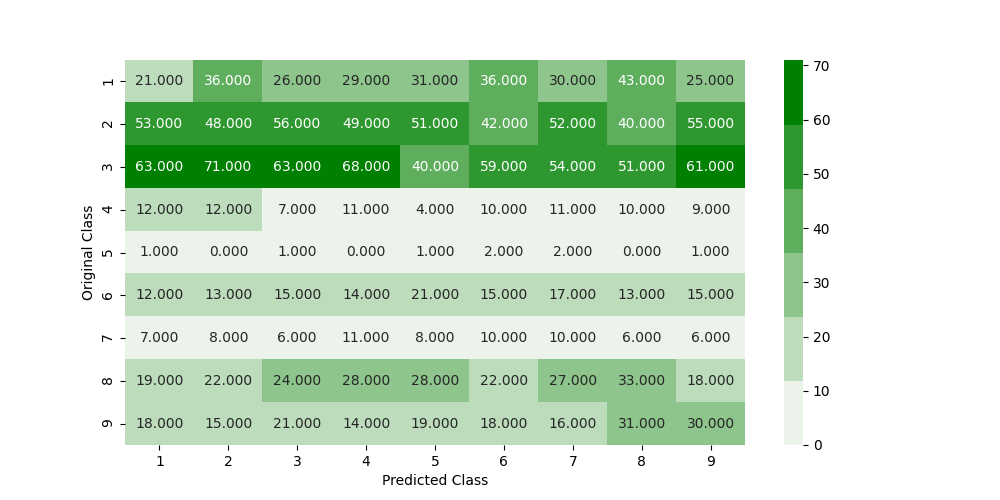

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


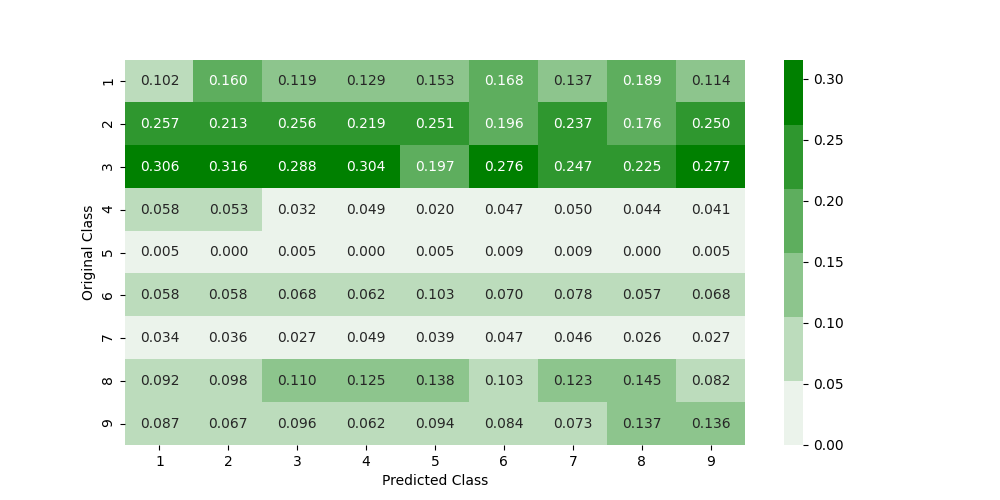

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


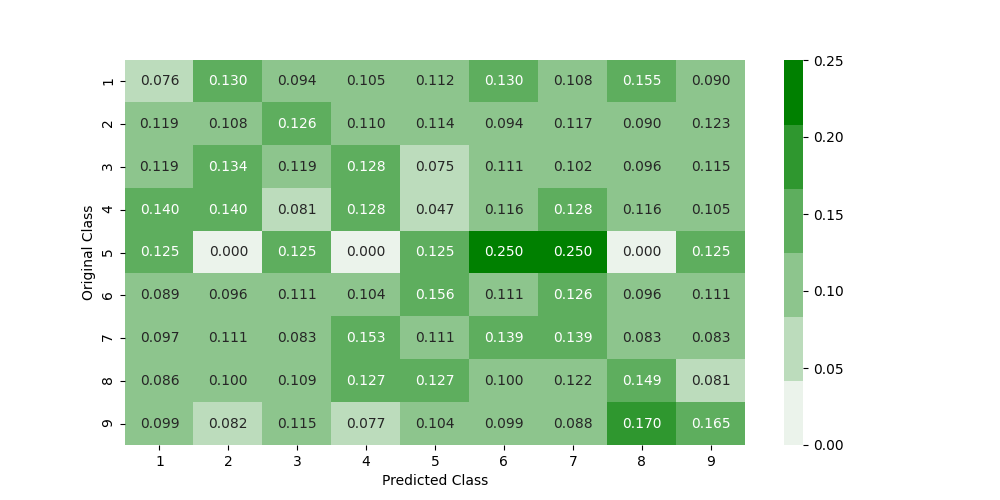

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
# ref: https://stackoverflow.com/a/18662466/4084039
# Ref: MicrosoftMalwareDetection.ipynb provided by Applied AI

models ={}
test_data_len = X_tes.shape[0]


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
loss = log_loss(y_tes,test_predicted_y, eps=1e-15)
print("Log loss on Test Data using Random Model",loss)

predicted_y =np.argmax(test_predicted_y, axis=1)
misclassif = plot_confusion_matrix(y_tes, predicted_y+1)

In [14]:
summary.append(["Random Model",loss,misclassif])

####  K Nearest Neighbour Classification

In [14]:
hyp = {'n_neighbors':np.arange(1,20,2)}

In [15]:
model = RandomizedSearchCV(KNeighborsClassifier(),scoring='neg_log_loss',param_distributions=hyp,verbose=2,n_jobs=-2)
model.fit(X_train,y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-2,
                   param_distributions={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])},
                   scoring='neg_log_loss', verbose=2)

<IPython.core.display.Javascript object>


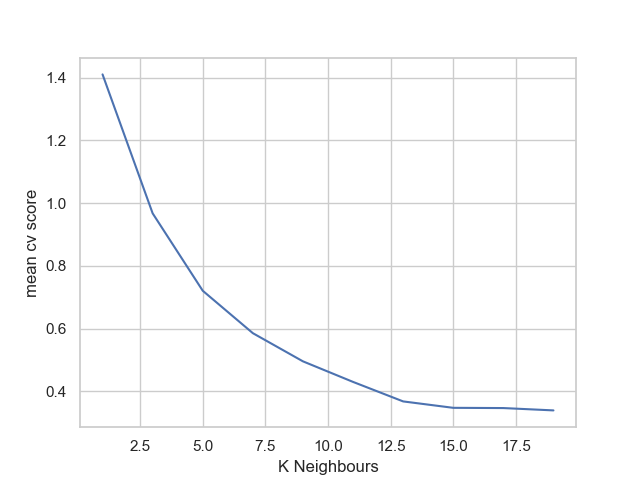

In [18]:
sns.set(style="whitegrid")
plt.plot(model.cv_results_['param_n_neighbors'].compressed(),-1*model.cv_results_['mean_test_score'])
plt.xlabel("K Neighbours")
plt.ylabel("mean cv score")
plt.show()

In [16]:
calib = CalibratedClassifierCV(model.best_estimator_, method="sigmoid",n_jobs=-2)
calib.fit(X_train,y_tr)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=19),
                       n_jobs=-2)

In [15]:
calib = pk.load(open("knn_final.pk","rb"))

In [32]:
# pk.dump(models['knn'],open('knn_final.pk','wb'))

Log loss on Test Data using Random Model 0.2119466582782148
Number of misclassified points  5.263157894736842
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


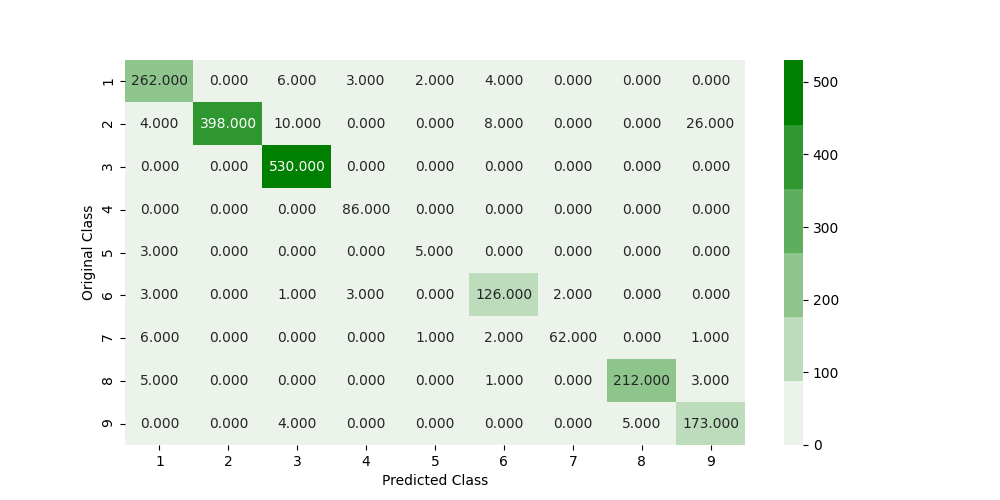

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


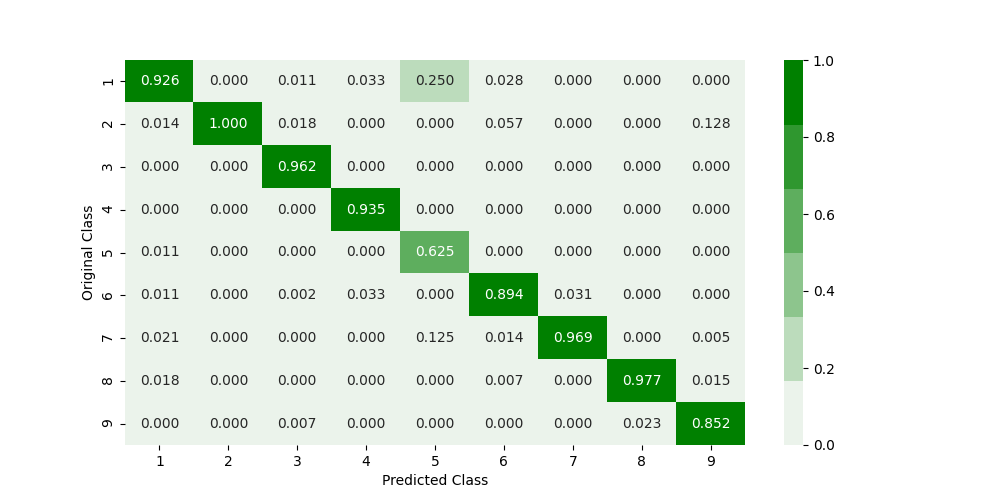

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


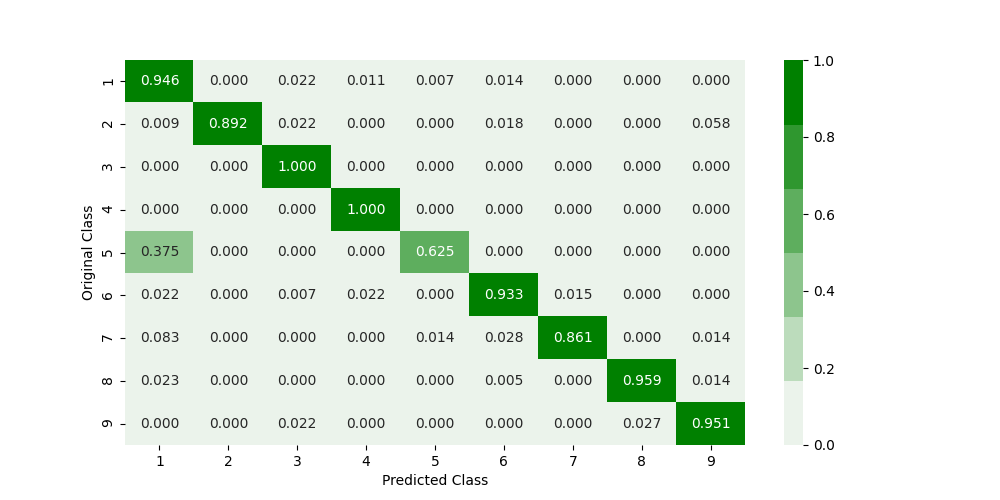

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
y_pred = calib.predict_proba(X_test)
loss = log_loss(y_tes,y_pred,eps=1e-15)
print("Log loss on Test Data using Random Model",loss)

predicted_y =np.argmax(y_pred, axis=1)
misclassif = plot_confusion_matrix(y_tes, predicted_y+1)

In [17]:
summary.append(["KNN",loss,misclassif])

In [18]:
models['knn'] = calib

In [19]:
calib=model=None
gc.collect()

28474

####  Logistic Regression

In [43]:
hyp = {'alpha':np.logspace(-3,3,7)}

In [22]:
model = GridSearchCV(SGDClassifier(loss='log',penalty='elasticnet',random_state=13,verbose=1),param_grid=hyp,verbose=2,n_jobs=-2)
model.fit(X_train,y_tr)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 33.89, NNZs: 3827, Bias: -117.575981, T: 8911, Avg. loss: 13.431731
Total training time: 2.58 seconds.
-- Epoch 2
Norm: 21.67, NNZs: 2490, Bias: -116.776222, T: 17822, Avg. loss: 0.255803
Total training time: 4.93 seconds.
-- Epoch 3
Norm: 17.78, NNZs: 2222, Bias: -116.283684, T: 26733, Avg. loss: 0.192753
Total training time: 7.03 seconds.
-- Epoch 4
Norm: 16.13, NNZs: 2098, Bias: -115.911022, T: 35644, Avg. loss: 0.168258
Total training time: 9.09 seconds.
-- Epoch 5
Norm: 15.10, NNZs: 1982, Bias: -115.640907, T: 44555, Avg. loss: 0.153931
Total training time: 11.07 seconds.
-- Epoch 6
Norm: 14.44, NNZs: 1892, Bias: -115.420029, T: 53466, Avg. loss: 0.138316
Total training time: 13.05 seconds.
-- Epoch 7
Norm: 14.03, NNZs: 1826, Bias: -115.231639, T: 62377, Avg. loss: 0.134567
Total training time: 14.99 seconds.
-- Epoch 8
Norm: 13.71, NNZs: 1761, Bias: -115.072736, T: 71288, Avg. loss: 0.128451
Total training time: 16.94 seconds.
-- Epoch 9
Norm: 13.47, NNZs: 1705, 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min finished


GridSearchCV(estimator=SGDClassifier(loss='log', penalty='elasticnet',
                                     random_state=13, verbose=1),
             n_jobs=-2,
             param_grid={'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             verbose=2)

Best alpha = 0.01  With Best Mean CV Score = 0.9745250850878071


<IPython.core.display.Javascript object>


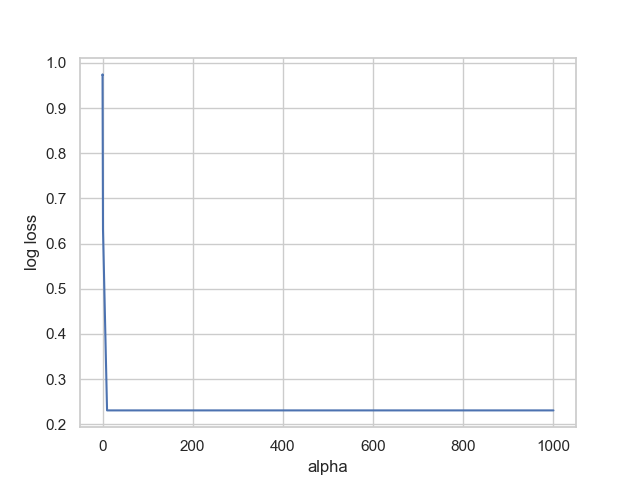

In [23]:
sns.set(style="whitegrid")
plt.plot(model.cv_results_['param_alpha'].compressed(),model.cv_results_['mean_test_score'])
plt.xlabel("alpha")
plt.ylabel("log loss")
print("Best alpha =",model.best_params_['alpha']," With Best Mean CV Score =",model.best_score_)
print("="*100)
plt.show()


In [24]:
calib = CalibratedClassifierCV(model.best_estimator_, method="sigmoid",n_jobs=-2)
calib.fit(X_train,y_tr)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, loss='log',
                                                    penalty='elasticnet',
                                                    random_state=13,
                                                    verbose=1),
                       n_jobs=-2)

In [30]:
# pk.dump(calib,open('lr_final.pk','wb'))

In [22]:
calib=pk.load(open("./lr_final.pk","rb"))

Log loss on Test Data using Random Model 0.1871996383580492
Number of misclassified points  2.2994379151762905
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


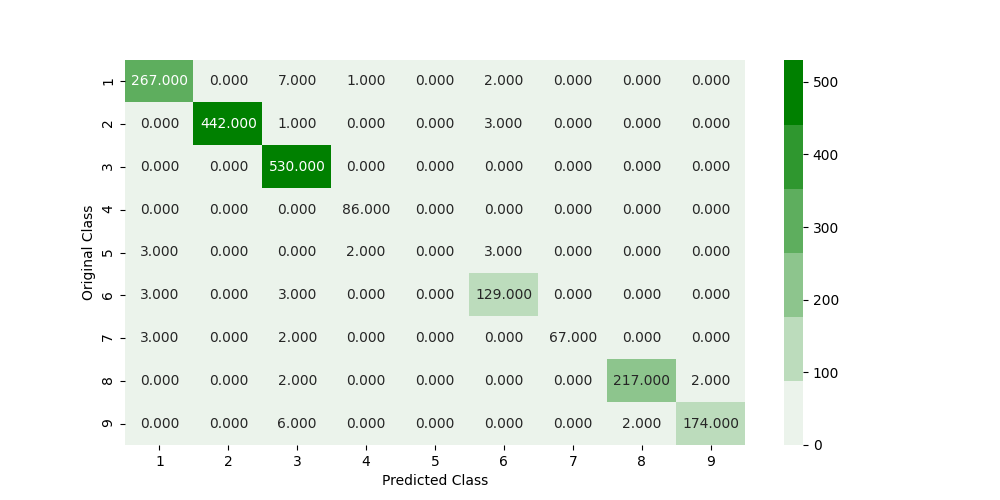

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


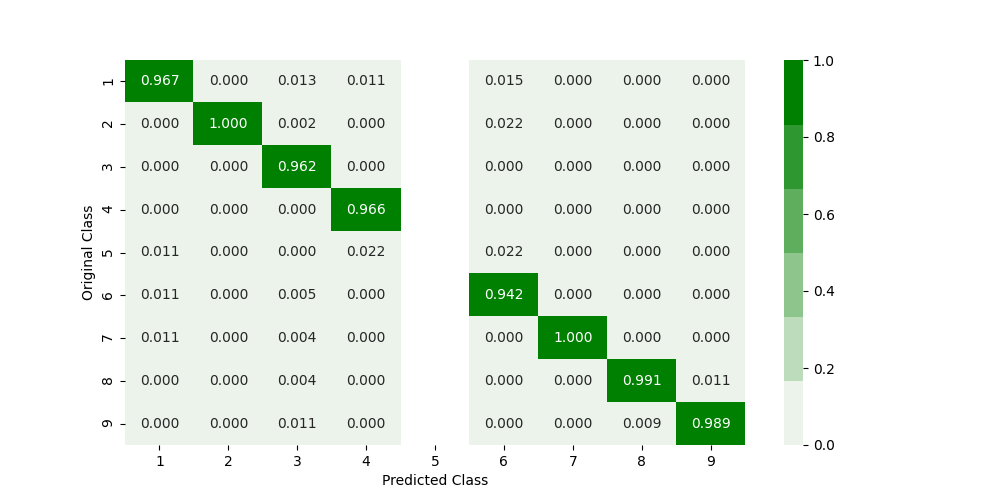

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


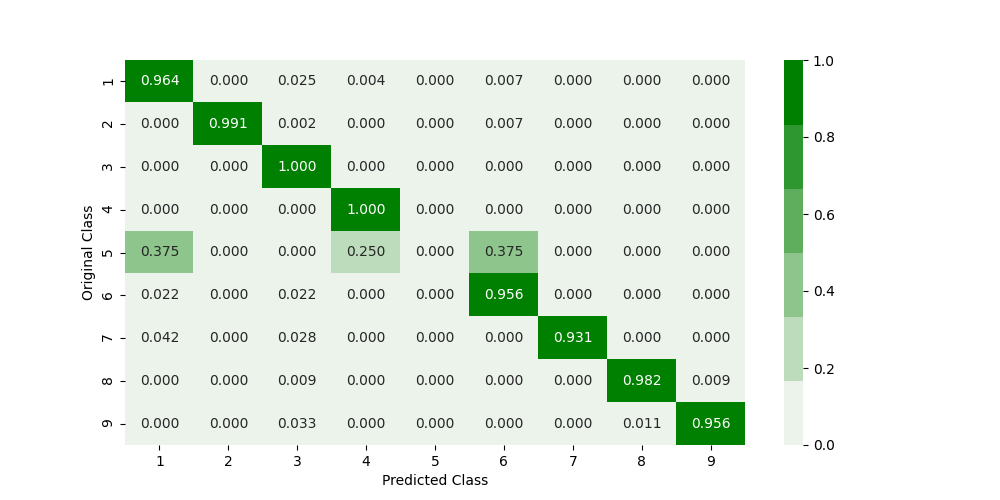

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
y_pred = calib.predict_proba(X_test)
loss = log_loss(y_tes,y_pred,eps=1e-15)
print("Log loss on Test Data using Random Model",loss)

predicted_y =np.argmax(y_pred, axis=1)
misclassif = plot_confusion_matrix(y_tes, predicted_y+1)

In [24]:
summary.append(["Logistic Regression",loss,misclassif])

In [25]:
models['lr'] = calib

In [26]:
model=None
calib=None
gc.collect()

84579

#### RBF SVM

In [29]:
hyp = {'C':np.logspace(-3,3,6),'gamma':np.logspace(-3,2,6)}

In [30]:
model = RandomizedSearchCV(SVC(degree=2,verbose=True,max_iter=500),param_distributions=hyp,n_iter=5,verbose=3)
model.fit(X_train,y_tr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LibSVM][CV 1/5] END ...............C=0.001, gamma=0.01;, score=0.678 total time= 4.9min
[LibSVM][CV 2/5] END ...............C=0.001, gamma=0.01;, score=0.693 total time= 4.7min
[LibSVM][CV 3/5] END ...............C=0.001, gamma=0.01;, score=0.694 total time= 4.8min
[LibSVM][CV 4/5] END ...............C=0.001, gamma=0.01;, score=0.687 total time= 4.6min
[LibSVM][CV 5/5] END ...............C=0.001, gamma=0.01;, score=0.680 total time= 4.9min
[LibSVM][CV 1/5] END C=0.25118864315095796, gamma=100.0;, score=0.094 total time= 5.6min
[LibSVM][CV 2/5] END C=0.25118864315095796, gamma=100.0;, score=0.096 total time= 6.1min
[LibSVM][CV 3/5] END C=0.25118864315095796, gamma=100.0;, score=0.097 total time= 5.2min
[LibSVM][CV 4/5] END C=0.25118864315095796, gamma=100.0;, score=0.095 total time= 5.0min
[LibSVM][CV 5/5] END C=0.25118864315095796, gamma=100.0;, score=0.094 total time= 4.9min
[LibSVM][CV 1/5] END ....C=63.0957344480193, gamma

RandomizedSearchCV(estimator=SVC(degree=2, max_iter=500, verbose=True),
                   n_iter=5,
                   param_distributions={'C': array([1.00000000e-03, 1.58489319e-02, 2.51188643e-01, 3.98107171e+00,
       6.30957344e+01, 1.00000000e+03]),
                                        'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
                   verbose=3)

In [31]:
calib = CalibratedClassifierCV(model.best_estimator_, method="sigmoid",n_jobs=-2)
calib.fit(X_train,y_tr)

CalibratedClassifierCV(base_estimator=SVC(C=63.0957344480193, degree=2,
                                          gamma=0.001, max_iter=500,
                                          verbose=True),
                       n_jobs=-2)

In [27]:
# pk.dump(calib,open("rbfsvm_final.pkl","wb"))
clf=pk.load(open("rbfsvm_final.pkl","rb"))

Log loss on Test Data using Random Model 0.3216952935264452
Number of misclassified points  5.3653551354113445
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


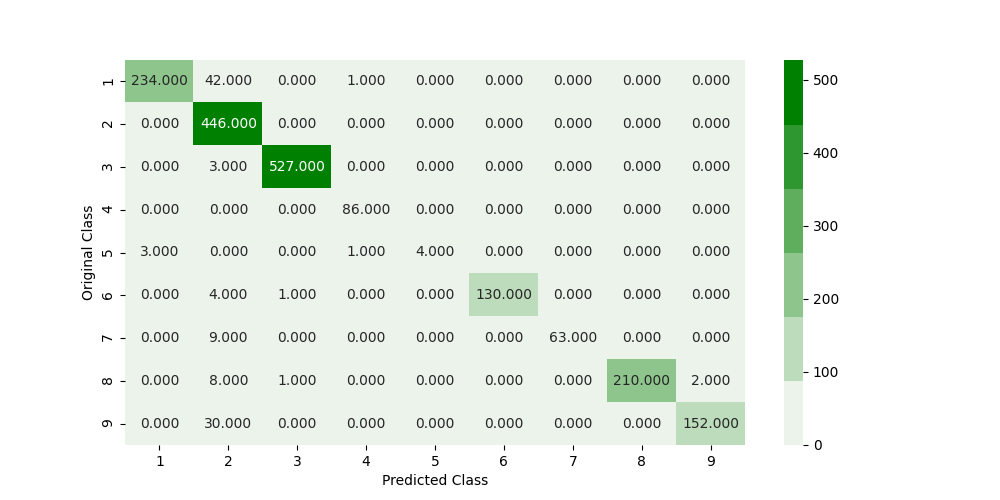

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


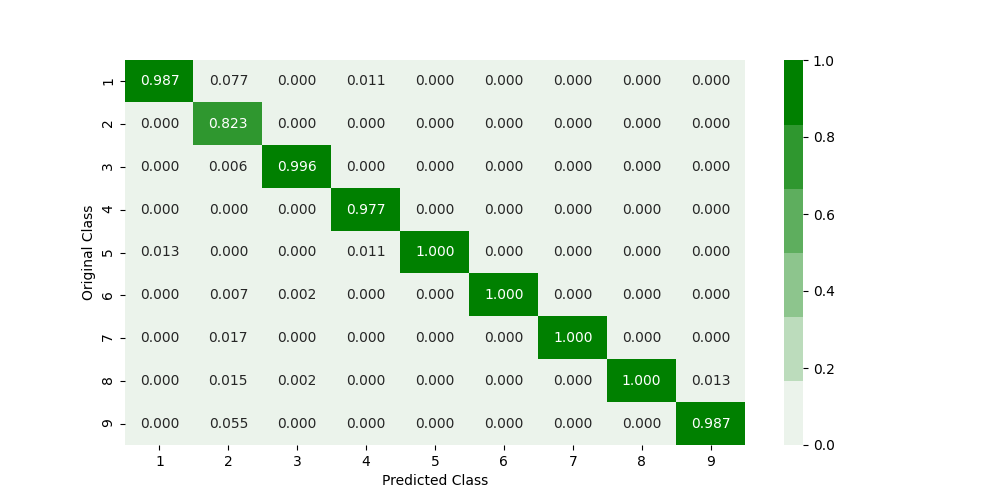

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


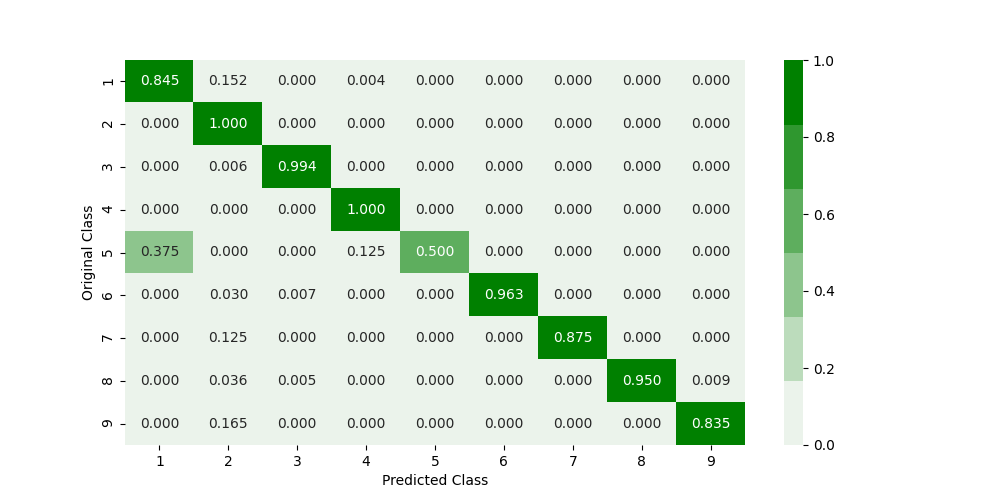

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
y_pred = clf.predict_proba(X_test)
loss = log_loss(y_tes,y_pred,eps=1e-15)
print("Log loss on Test Data using Random Model",loss)

predicted_y =np.argmax(y_pred, axis=1)
misclassif = plot_confusion_matrix(y_tes, predicted_y+1)

In [29]:
summary.append(["RBF-SVM",loss,misclassif])

In [30]:
models['rbf-svm'] = clf

In [31]:
calib=None
model=None
gc.collect()

20

#### Random Forest 

In [63]:
hyp = {"n_estimators":[10,50,100,500,1000,2000,3000]}             

In [64]:
model = RandomizedSearchCV(RandomForestClassifier(random_state=25,verbose=1,n_jobs=-1),param_distributions=hyp,n_iter=12,cv=4,verbose=2)
model.fit(X_train,y_tr)

C:\Users\sista\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning:

The total space of parameters 7 is smaller than n_iter=12. Running 7 iterations. For exhaustive searches, use GridSearchCV.



Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV] END ....................................n_estimators=10; total time=   8.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV] END ....................................n_estimators=10; total time=   3.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV] END ....................................n_estimators=10; total time=   2.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


[CV] END ....................................n_estimators=10; total time=   2.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV] END ....................................n_estimators=50; total time=   3.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV] END ....................................n_estimators=50; total time=   3.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV] END ....................................n_estimators=50; total time=   5.5s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV] END ....................................n_estimators=50; total time=   4.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END ...................................n_estimators=100; total time=   5.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END ...................................n_estimators=100; total time=   6.5s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END ...................................n_estimators=100; total time=   6.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END ...................................n_estimators=100; total time=   5.5s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END ...................................n_estimators=500; total time=  19.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END ...................................n_estimators=500; total time=  18.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................................n_estimators=500; total time=  18.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................................n_estimators=500; total time=  18.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[CV] END ..................................n_estimators=1000; total time=  34.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[CV] END ..................................n_estimators=1000; total time=  34.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   35.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.4s finished


[CV] END ..................................n_estimators=1000; total time=  37.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   35.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.4s finished


[CV] END ..................................n_estimators=1000; total time=  37.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)

[CV] END ..................................n_estimators=2000; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)

[CV] END ..................................n_estimators=2000; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)

[CV] END ..................................n_estimators=2000; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)

[CV] END ..................................n_estimators=2000; total time= 1.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)

[CV] END ..................................n_estimators=3000; total time= 2.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)

[CV] END ..................................n_estimators=3000; total time= 2.1min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)

[CV] END ..................................n_estimators=3000; total time= 2.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)

[CV] END ..................................n_estimators=3000; total time= 2.1min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished


RandomizedSearchCV(cv=4,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=25,
                                                    verbose=1),
                   n_iter=12,
                   param_distributions={'n_estimators': [10, 50, 100, 500, 1000,
                                                         2000, 3000]},
                   verbose=2)

Best alpha = 50  With Best Mean CV Score = 0.9941644147757367


<IPython.core.display.Javascript object>


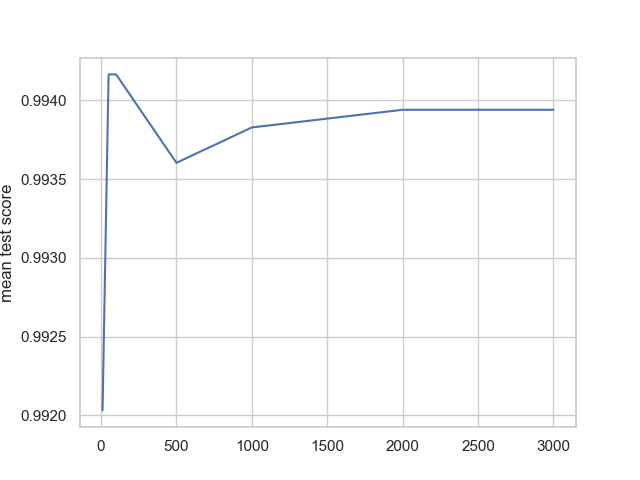

In [70]:
sns.set(style="whitegrid")
plt.plot(model.cv_results_['param_n_estimators'].compressed(),model.cv_results_['mean_test_score'])
plt.xlabel("")
plt.ylabel("mean test score")
print("Best alpha =",model.best_params_['n_estimators']," With Best Mean CV Score =",model.best_score_)
print("="*100)
plt.show()

In [ ]:
calib = CalibratedClassifierCV(model.best_estimator_,method='sigmoid',n_jobs=-2)
calib.fit(X_train,y_tr)

In [36]:
# pk.dump(calib,open("rf_final.pk","wb"))
calib=pk.load(open("rf_final.pk","rb"))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0

Log loss on Test Data using Random Forest Classifier 0.020278156052861988
Number of misclassified points  0.3065917220235054
-------------------------------------------------- Confusion matrix --------------------------------------------------


[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


<IPython.core.display.Javascript object>


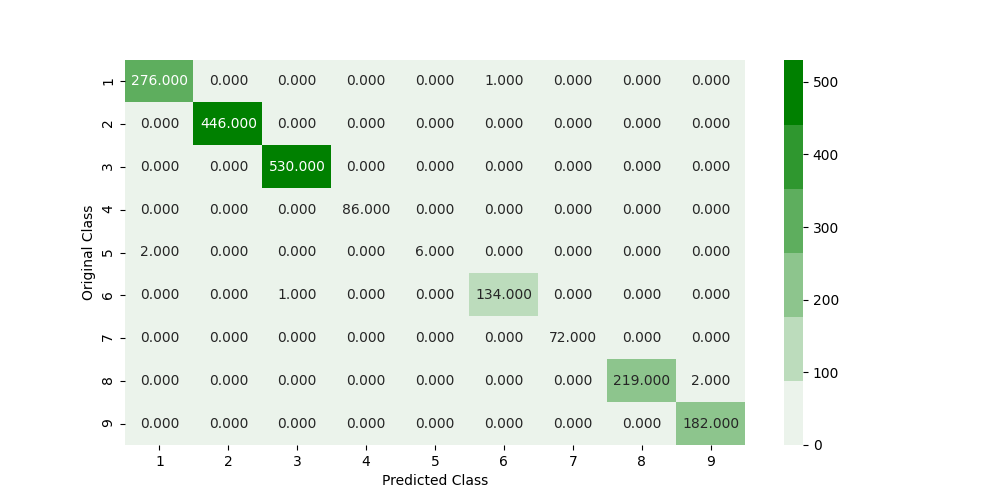

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


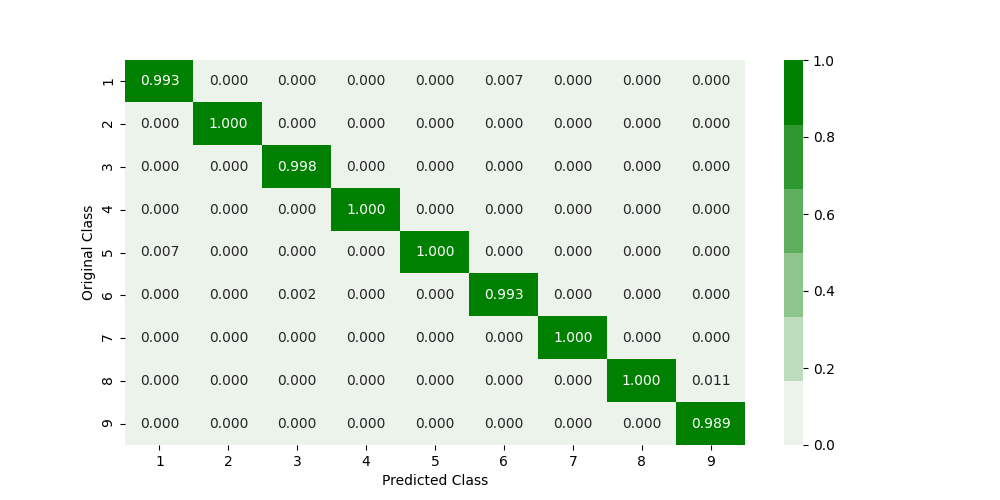

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


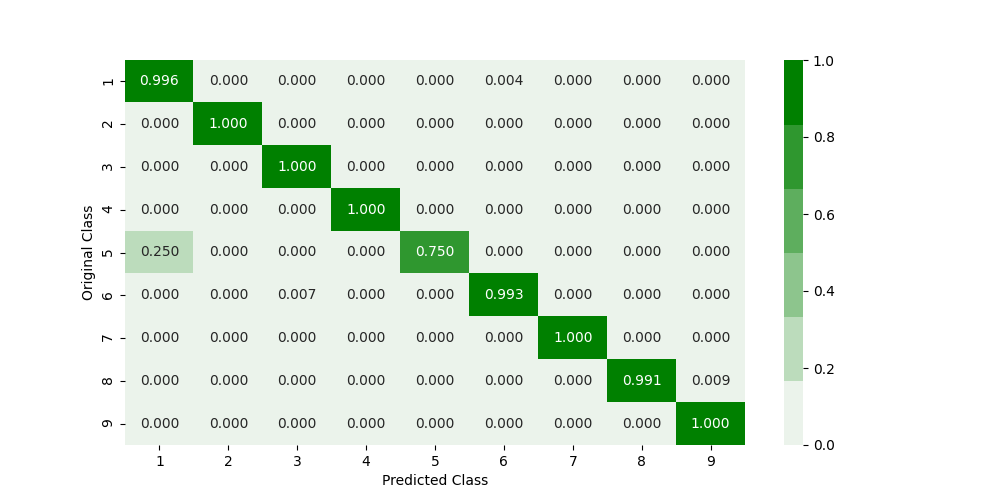

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [37]:
y_pred = calib.predict_proba(X_test)
loss = log_loss(y_tes,y_pred,eps=1e-15)
print("Log loss on Test Data using Random Forest Classifier",loss)

predicted_y =np.argmax(y_pred, axis=1)
misclassif = plot_confusion_matrix(y_tes, predicted_y+1)

In [38]:
summary.append(["RF",loss,misclassif])

In [39]:
models['rf'] = calib

In [40]:
clf=None
model=None
gc.collect()

85099

#### Xtreme Gradient Boosting

In [12]:
hyp={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

In [17]:
model=RandomizedSearchCV(XGBClassifier(verbose=3),param_distributions=hyp,verbose=10,n_jobs=5)
model.fit(X_train,y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(verbose=3), n_jobs=5,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.5, 1],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000],
                                        'subsample': [0.1, 0.3, 0.5, 1]},
                   verbose=10)

In [ ]:
# pk.dump(model,open("xgb_final.pk","wb"))
# model = pk.load(open("xgb_final.pk","rb"))

In [19]:
x1=model.cv_results_['param_n_estimators']
y1=model.cv_results_['param_max_depth']
z1=model.cv_results_['mean_test_score']
y2=model.cv_results_['param_subsample']
y3=model.cv_results_['param_colsample_bytree']
y4=model.cv_results_['param_learning_rate']

In [21]:
scene1 = dict(                                      #set labels for 2st plot
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='Mean CV Score'),)
scene2 = dict(                                      #set labels for 2st plot
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='subsample percentage'),
        zaxis = dict(title='Mean CV Score'),)
scene3 = dict(                                      #set labels for 2st plot
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='colsample_bytree percentage'),
        zaxis = dict(title='Mean CV Score'),)
scene4 = dict(                                      #set labels for 2st plot
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='learning_rate'),
        zaxis = dict(title='Mean CV Score'),)
fig =make_subplots(
    rows=2, cols=2,
    specs=[[{'is_3d': True}, {'is_3d': True}],[{'is_3d': True}, {'is_3d': True}]],
    subplot_titles=("Combination 1", "Combination 2","Combination 3","Combination 4")
    )
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'Cross validation')
trace2 = go.Scatter3d(x=x1,y=y2,z=z1, name = 'Cross validation')
trace3 = go.Scatter3d(x=x1,y=y3,z=z1, name = 'Cross validation')
trace4 = go.Scatter3d(x=x1,y=y4,z=z1, name = 'Cross validation')

# data = [trace1]
# data = [trace2]

fig.add_trace(trace1,row=1,col=1)
fig.add_trace(trace2,row=1,col=2)
fig.add_trace(trace3,row=2,col=1)
fig.add_trace(trace4,row=2,col=2)



fig['layout']['scene'].update(scene1)
fig['layout']['scene2'].update(scene2)
fig['layout']['scene3'].update(scene3)
fig['layout']['scene4'].update(scene4)



offline.iplot(fig, filename='3d-scatter-colorscale')

In [45]:
# Ref: MicrosoftMalwareDetection.ipynb provided by Applied AI

x_cfl=XGBClassifier(n_estimators=500,max_depth=3,learning_rate=0.1,subsample=1,colsample_bytree=0.1)
x_cfl.fit(X_train,y_tr)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid',n_jobs=-2)
c_cfl.fit(X_train,y_tr)

predict_y = x_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_tr, predict_y))
predict_y = x_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_tes, predict_y))

C:\Users\sista\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[13:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train loss 0.00039797665704385707
test loss 0.0073680679447485405


In [47]:
# pk.dump(c_cfl,open("xgb_final2.pk","wb"))
# x_cfl = pk.load(open("xgb_final2.pk","rb"))

Log loss on Test Data using XGBoost Classifier 0.0073680679447485405
Number of misclassified points  0.2043944813490036
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


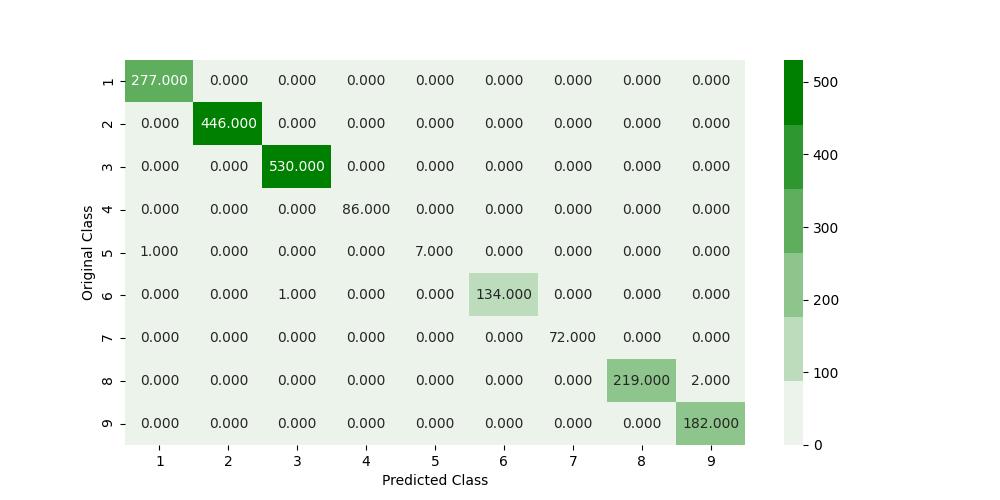

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


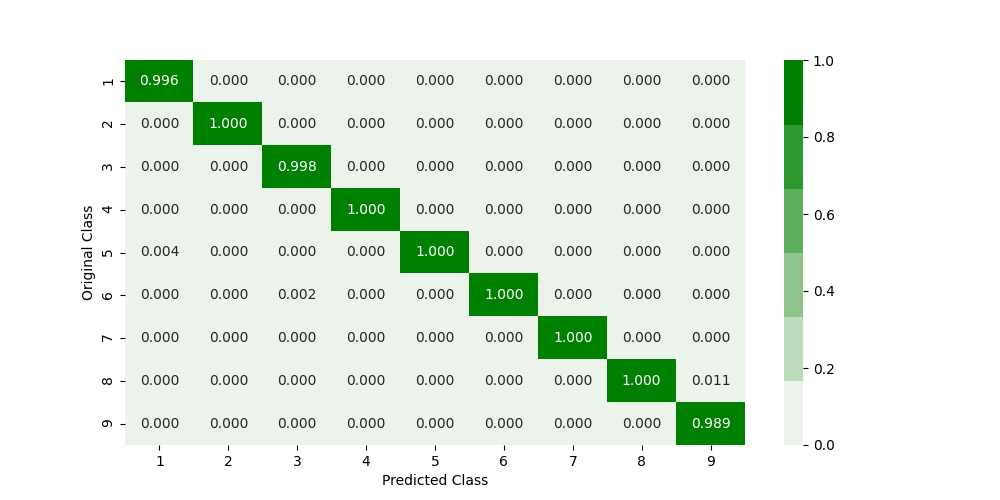

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


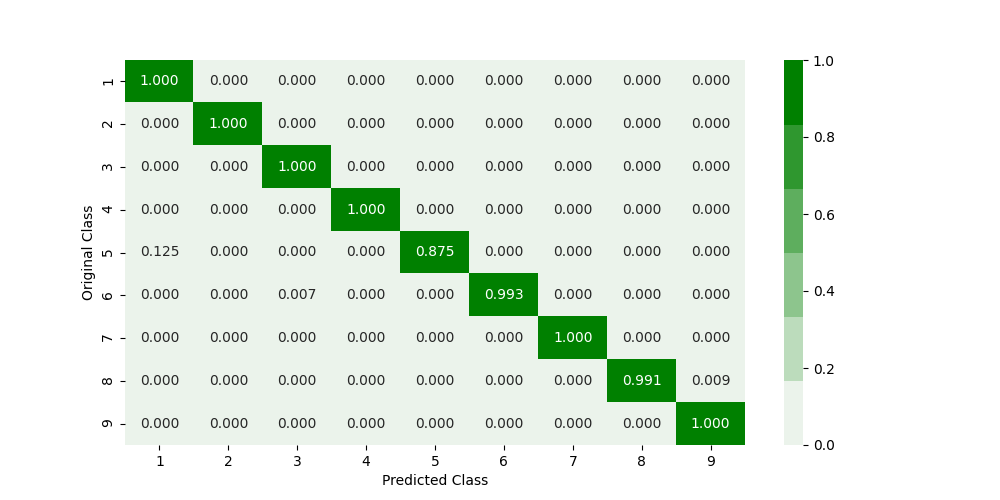

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [49]:
y_pred = c_cfl.predict_proba(X_test)
loss = log_loss(y_tes,predict_y,eps=1e-15)
print("Log loss on Test Data using XGBoost Classifier",loss)

predicted_y =np.argmax(predict_y, axis=1)
misclassif = plot_confusion_matrix(y_tes, predicted_y+1)

In [51]:
summary.append(["XGBClassifier",loss,misclassif])

In [52]:
models['xgb'] = calib

In [66]:
from tabulate import tabulate

In [67]:
print(tabulate(summary,headers='firstrow',tablefmt='grid'))

+---------------------+------------+-------------------------+
| Model               |   Log-Loss |   Misclassified Percent |
+=====================+============+=========================+
| Random Model        | 2.45585    |               88.1451   |
+---------------------+------------+-------------------------+
| KNN                 | 0.211947   |                5.26316  |
+---------------------+------------+-------------------------+
| Logistic Regression | 0.1872     |                2.29944  |
+---------------------+------------+-------------------------+
| RBF-SVM             | 0.321695   |                5.36536  |
+---------------------+------------+-------------------------+
| RF                  | 0.0202782  |                0.306592 |
+---------------------+------------+-------------------------+
| XGBClassifier       | 0.00736807 |                0.204394 |
+---------------------+------------+-------------------------+


### Further Ideas:
- I really want to implement pseudo-labelling approach and check how it will improve the performance.
- I have implemented 4-gram hash encoded, I want to see how the model will change if I use normal 4-gram vectors.
- I really want to dive more into image features like texture of the pixels etc and implement all techniques discussed in [link_to_research_paper](http://vizsec.org/files/2011/Nataraj.pdf)
- I've learnt many concepts related to parallel computing, Dask, Multiprocessing library, Threading etc.. to reduce the time complexity, and I'm very eager to know more about these things as they really helped me with processing time. I guess I reduced time complexity by many folds and run everything on my local system.

## Thank You For This Assignment, By Solving this I've learnt many technical skills as well as personal skills.